In [1]:
#Add folder to sys path to import modules from sub folders
import sys
sys.path.insert(0, r'C:\Users\SaANTIAGO\Google Drive Streaming\My Drive\18_UT_RAPID\cuttings_sensor')

In [58]:
#from src import file_dialog, text_extraction
from src.text_extraction import *
from src.file_dialog import *
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import matplotlib.style as style
style.use('tableau-colorblind10')
#style.use('seaborn-notebook')
style.use('seaborn-whitegrid')

In [3]:
#files_directory = get_directory('Select directory containing volume files')

In [4]:
directory, files = get_directory_files('.csv')

In [26]:
#Read and concatenate all files in Volume Folder
def concat_volume_files(files: list):
    volume_data = pd.DataFrame([], columns=[0, 1, 2])
    for file in files:
        #print(file)
        try:
            volume_data_i = pd.read_csv(file, header=None)
            volume_data = pd.concat([volume_data, volume_data_i])
        except:
            next
    #Reset index
    volume_data.reset_index(drop=True, inplace=True)
    return volume_data

def rename_columns(volume_data):
    #Rename Columns
    volume_data = volume_data.rename(columns={0: 'laser_stamp', 
                                      1: 'date_time',
                                      2: 'volume_m3'})
    return volume_data

In [198]:
def reformat_milliseconds(x):
    return x.replace(x, x[:19])#str('.' + x[20:]))

def convert_to_date(x):
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    except:
        return np.nan #Set to np.nan the values not available for conversion

def reformat_date(volume_data):
    #Reformat date - change ':' for '.' separator from seconds to milliseconds
    volume_data['date_time'] = volume_data['date_time'].apply(lambda x: reformat_milliseconds(x))
    volume_data['date_time'] = volume_data['date_time'].apply(lambda x: convert_to_date(x))
    return volume_data

In [199]:
#Concat Volume Data Files
volume_data = concat_volume_files(files)
#rename Columns
volume_data = rename_columns(volume_data)
#Reformat Date - change ':' for '.' separator from seconds to milliseconds, read as datetime
volume_data = reformat_date(volume_data)

In [201]:
#Get Normalized Differential Volume (m3/hr)
volume_data['diff_vol_m3_per_hr'] = volume_data['volume_m3'].diff()*(3600/(volume_data['date_time'].diff()/(pd.Timedelta(seconds=1))))

In [12]:
def filter_outliers(df, column: str):
    """Filters outliers from selected column.
    """
    col_mean = df[column].mean()
    col_std = df[column].std()
    low_limit = col_mean - 3*col_std
    high_limit = col_mean + 3*col_std
    df[column] = df[column][(df[column] < high_limit) &
                                    (df[column] > low_limit)]
    return df[column]

In [33]:
volume_data['volume_m3'] = filter_outliers(volume_data, 'volume_m3')

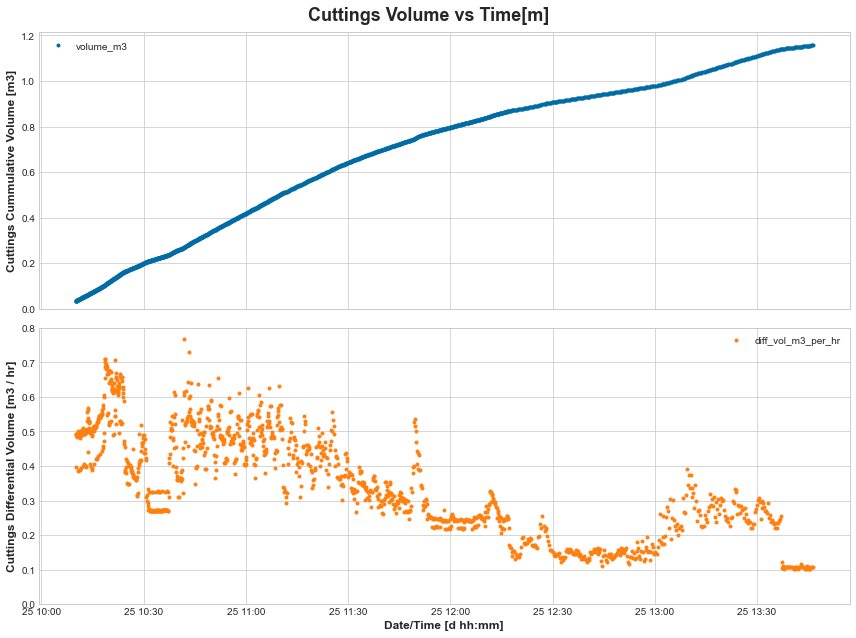

In [203]:
initial_date = convert_to_date('2022-06-25 10:10:00')
final_date = convert_to_date('2022-06-25 14:00:00')

mask = (volume_data['date_time'] > initial_date)# &
        #(volume_data['date_time'] < final_date)]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig_name = 'Cuttings Volume vs Time.png'
directory = get_directory('Select Saving Directory', as_path=False)
file_path = '\\'.join([directory, fig_name])

plt.figure(figsize=(12, 9))
plt.suptitle('Cuttings Volume vs Time[m]', fontsize = 18, fontweight = 'bold')#, y = 1.02)
ax1 = plt.subplot(2,1,1)
plt.plot(volume_data['date_time'][mask], 
         volume_data['volume_m3'][mask],
         '.',
         label='volume_m3',
         color = colors[0])

plt.legend()
plt.ylabel('Cuttings Cummulative Volume [m3]', fontsize = 12, fontweight = 'bold')
plt.ylim(0)
for label in plt.gca().get_xticklabels():
    label.set_visible(False)
plt.subplot(2,1,2, sharex = ax1)
plt.plot(volume_data['date_time'][mask], 
         volume_data['diff_vol_m3_per_hr'][mask],
         '.',
         label='diff_vol_m3_per_hr',
         color = colors[1])

plt.legend()
plt.ylabel('Cuttings Differential Volume [m3 / hr]', fontsize = 12, fontweight = 'bold')
plt.xlabel('Date/Time [d hh:mm]', fontsize = 12, fontweight = 'bold')
plt.ylim(0)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig(file_path)
plt.show()

In [103]:
#Get well data
well_data = pd.read_csv(get_data_file('Select Well Data File'))
well_data['DateTime'] = pd.to_datetime(well_data['DateTime'])
mask = (well_data['DateTime'] > initial_date) & (well_data['DateTime'] < final_date)
#Rename Well Data DateTime to merge with volume_data date_time
well_data.rename(columns={'DateTime': 'date_time'}, inplace=True)
volume_data.date_time = pd.to_datetime(volume_data.date_time)

#Merge to volume_data
volume_data = volume_data.merge(well_data, 
                on='date_time')

In [224]:
volume_data.columns

Index(['laser_stamp', 'date_time', 'volume_m3', 'diff_vol_m3_per_hr',
       'Hole Depth', 'Bit Position', 'Block Height', 'Diff Press',
       'Flow Out Percent', 'Hook Load', 'ROP - Average', 'Pump SPM 1',
       'Strks - Pump 1', 'Pump SPM 2', 'Strks - Pump 2', 'Top Drive RPM',
       'Top Drive Torque', 'Pump Pressure', 'Mud Volume', 'Flow In Rate',
       'Bit Weight', 'Pump SPM 3', 'Strks - Pump 3', 'Gamma Ray',
       'Toolface Grav', 'Toolface Mag', 'Trip Tank 1 Volume',
       'Trip Tank 2 Volume', 'Survey Inclination ', 'Survey Azimuth',
       'Trip Tank Volume Change'],
      dtype='object')

In [244]:
#Define Columns to Plot
y_columns = volume_data.columns[[2,3,4, 5, 9, 10, 15, 18, 19]]# ['volume_m3', 'Bit Weight', 'ROP - Average', 'Top Drive RPM', 'Top Drive Torque', 'Pump Pressure', 'Mud Volume', 'Flow In Rate']# well_data.columns[1:10] #Well Log Parameters columns
x = volume_data['date_time'][mask] #Define x-axis as Date_Time

In [260]:
y_columns = ['volume_m3', 
             'diff_vol_m3_per_hr',
             ['ROP - Average', 'Block Height'],
             'Top Drive RPM', 
             'Flow In Rate', 'Flow Out Percent',
             ['Hole Depth', 'Bit Position'],
             ['Hook Load','Bit Weight'],
             'Mud Volume']

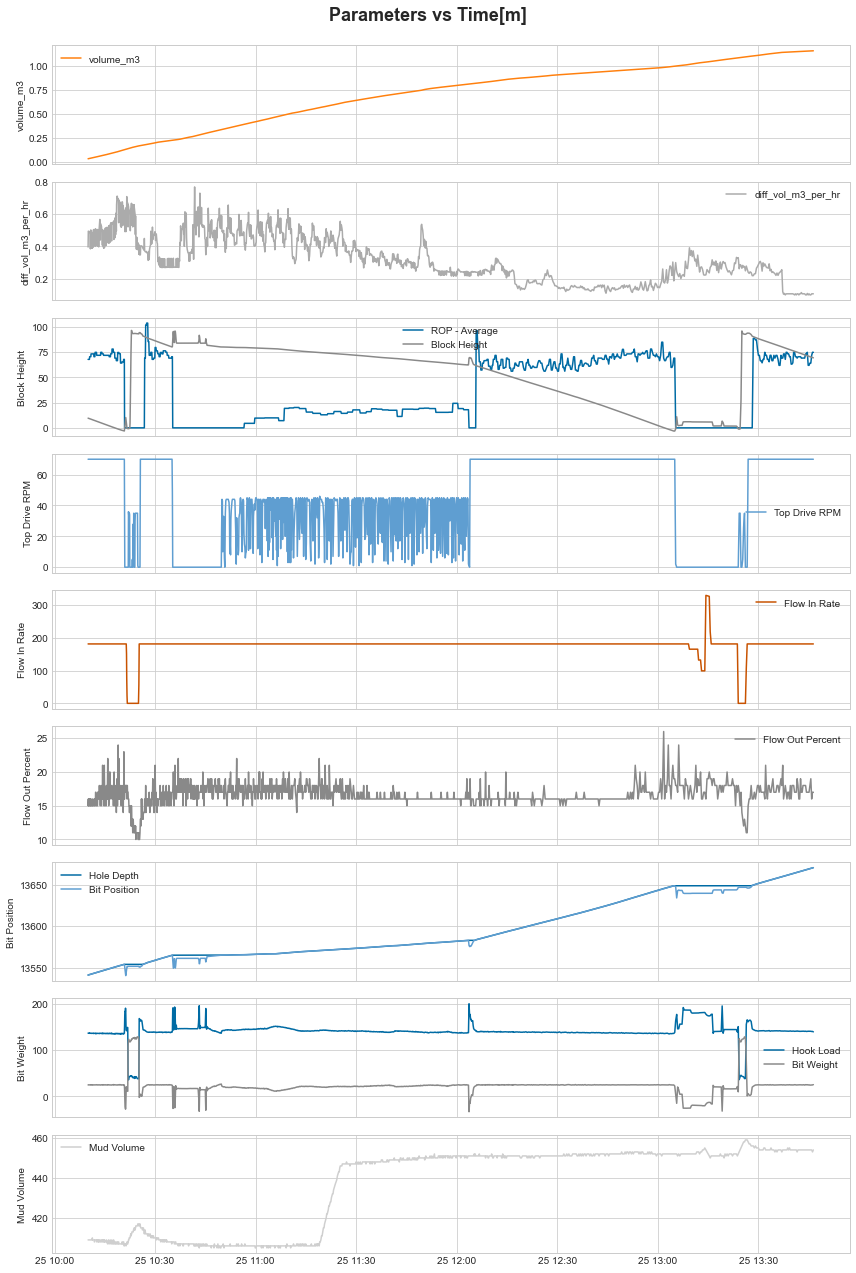

In [261]:
#Set Colormap
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
tot_subplots = len(y_columns)
i = 0
plt.figure(figsize=(12, 2*tot_subplots))
plt.suptitle('Parameters vs Time[m]', fontsize = 18, fontweight = 'bold')
for col in y_columns:
    i += 1
    if i == 1:
        color = colors[(i%(len(colors)))]
        ax1 = plt.subplot(tot_subplots, 1, i)
        plt.plot(x, volume_data[col][mask], label = col, color = color)
        plt.ylabel(col)
        plt.legend()
        for label in plt.gca().get_xticklabels():
            label.set_visible(False)
    elif i == tot_subplots:
        color = colors[(i%(len(colors)))]
        plt.subplot(tot_subplots, 1, i, sharex = ax1)
        plt.plot(x, volume_data[col][mask], label = col, color = color)
        plt.ylabel(col)
        plt.legend()
    else:
        plt.subplot(tot_subplots, 1, i, sharex = ax1)
        if type(col)==list:
            for col_i in col:
                j += i + i
                color = colors[(j%(len(colors)))]
                plt.plot(x, volume_data[col_i][mask], label = col_i, color = color)
                plt.ylabel(col_i)
        else:
            color = colors[(i%(len(colors)))]
            plt.plot(x, volume_data[col][mask], label = col, color = color)
            plt.ylabel(col)
        plt.legend()        
        for label in plt.gca().get_xticklabels():
                label.set_visible(False)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(r'C:\Users\SaANTIAGO\Google Drive Streaming\My Drive\18_UT_RAPID\cuttings_sensor\parameters.png')
plt.show()

In [240]:
#Save new data
well_data_file = 'well_data.csv'
volume_data_file = 'volume_data.csv'
save_dataframe(well_data_file, well_data)
save_dataframe(volume_data_file, volume_data)